In [2]:
%load_ext lab_black

In [1]:
from cartes.osm import Overpass, Nominatim
import logging

logging.getLogger().setLevel(logging.INFO)

/opt/miniconda3/envs/py39/lib/python3.9/site-packages/cartes/osm/requests.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [90]:
!wget https://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_21_09.zip

--2021-11-05 21:31:39--  https://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_21_09.zip
Resolving localhost (localhost)... 127.0.0.1
Connecting to localhost (localhost)|127.0.0.1|:8123... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2248362 (2,1M) [application/zip]
Saving to: ‘srtm_21_09.zip’

srtm_21_09.zip      100%[===================>]   2,14M  1003KB/s    in 2,2s    

2021-11-05 21:31:42 (1003 KB/s) - ‘srtm_21_09.zip’ saved [2248362/2248362]



In [147]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = "EPSG:3448"  # Jamaica projection

with rasterio.open("srtm_21_09/srtm_21_09.tif") as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update(
        {"crs": dst_crs, "transform": transform, "width": width, "height": height}
    )

    with rasterio.open("jamaica_3448.tif", "w", **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )

In [32]:
import rasterio
from rasterio.plot import show

img = rasterio.open("jamaica_3448.tif")

In [34]:
%load_ext lab_black

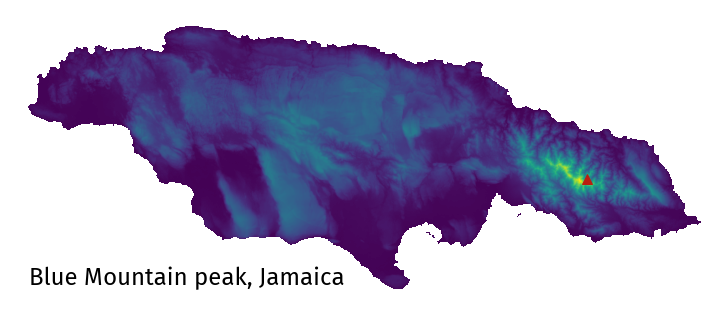

In [41]:
from cartes.osm import Nominatim
from cartes.crs import EPSG_3448, PlateCarree
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=EPSG_3448()))

show(img, ax=ax)
peak = Nominatim.search("Blue Mountain peak")

ax.plot(
    float(peak.lon),
    float(peak.lat),
    marker="^",
    markersize=10,
    color="#bb1e10",
    transform=PlateCarree(),
)

ax.spines["geo"].set_visible(False)

text = AnchoredText(
    "Blue Mountain peak, Jamaica",
    loc=3,
    frameon=False,
    prop={"size": 24, "fontname": "Fira Sans"},
)
ax.add_artist(text)

fig.set_tight_layout(True)
fig.subplots_adjust(wspace=0.05, hspace=0)
fig.savefig("challenge_day8.png", dpi=300, facecolor="white")